In [1]:
from pathlib import Path
from indigo import Indigo
import numpy as np
import pandas as pd
import asyncio
import shutil

from substructure_finder import BucketsInitializer
from substructure_finder.search_engines import SearchEngine, ThreadPoolSearchEngine, ProcessPoolSearchEngine
from substructure_finder import DbFilesystem

import fp_utils
from fp_utils.finders import Finder
from fp_utils.testing import FinderSpeedTester
from fp_utils.catch_time import CatchTime

In [2]:
fp_utils.settings.init_fp_utils()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
base_drives_dir = Path('../data/drives/')
data_dirs = [base_drives_dir / str(i) for i in range(1, 4 + 1)]
other_dir = Path('../data/drives/0/')
db_fs = DbFilesystem(data_dirs, other_dir)
zero_columns_name = '../data/zero_columns'

Path(zero_columns_name).exists(), all(map(lambda x: x.is_dir(), data_dirs)), other_dir.is_dir()

(True, True, True)

# Build structure

In [9]:
bt_cols_cnt = 120
raw_db_name = 'raw_db_2'
db_name = 'test_db'

In [10]:
db_tree_path = db_fs.tree_path(db_name)
db_tree_path.parent.mkdir(parents=True, exist_ok=True)
with db_fs.tree_path(raw_db_name).open('rb') as fp_in:
    with db_tree_path.open('wb') as fp_out:
        shutil.copyfileobj(fp_in, fp_out)

In [11]:
initializer = BucketsInitializer(db_fs, raw_db_name, db_name, columns_count=bt_cols_cnt)

In [9]:
%%time
initializer.init_buckets()

Start init 241
Start init 3388
Start init 3058
Start init 4052
Start init 3318
Start init 3778
Start init 4004
Start init 3924
Finish init 241
Start init 663
Finish init 3924
Start init 2003
Finish init 3058
Start init 1235
Finish init 3318
Start init 1445
Finish init 3778
Start init 1857
Finish init 4004
Start init 2011
Finish init 4052
Start init 2121
Finish init 3388
Start init 1513
Finish init 663
Start init 916
Finish init 2003
Start init 2004
Finish init 1235
Start init 1236
Finish init 1445
Start init 1446
Finish init 2011
Start init 2012
Finish init 1857
Start init 1858
Finish init 2121
Start init 2122
Finish init 1513
Start init 1514


KeyboardInterrupt: 

# Search Queries

In [6]:
with open(zero_columns_name, 'r') as f:
    zero_columns = list(map(int, f.read().split()))
assert list(sorted(zero_columns)) == zero_columns

In [7]:
full_columns = list(sorted(set(range(3736)) - set(zero_columns)))

In [8]:
def bin_format(number, num_of_bits=3736):
    fp = list(map(int, list(bin(int(number, 16))[2:].zfill(num_of_bits))))
    return np.fromiter(fp, dtype=int)

In [9]:
def smiles_to_fingerprint(smiles):
    indigo_mol_to_test = Indigo().loadMolecule(smiles)
    full_fp = bin_format(indigo_mol_to_test.fingerprint("sub").toString())
    return np.fromiter(pd.Series(full_fp)[full_columns].values, dtype=bool)

In [10]:
@CatchTime("search")
def search(smiles: str, finder: Finder, ans_count=None):
    fp = smiles_to_fingerprint(smiles)
    return list(finder.find(fp, ans_count))

In [11]:
class ComplexFinder(SearchEngine, Finder):
    def find_all(self, fp):
        return self.search(fp)

In [12]:
class ThreadPoolFinder(ThreadPoolSearchEngine, Finder):   
    def find_all(self, fp):
        return self.search(fp)

In [13]:
class ProcessPoolFinder(ProcessPoolSearchEngine, Finder):
    def find_all(self, fp):
        return self.search(fp)

In [14]:
with open('../data/pubchem_994_queries.txt', 'r') as f:
    queries = list(map(lambda x: x.split()[0], f.read().strip().split('\n')))

In [15]:
len(queries), queries[:10]

(157,
 ['Cc1c[n]c2[nH]ccc2c1Cl',
  'OC(=O)c1c[n]c2[nH]ccc2c1Cl',
  'Cc1c(Cl)c[n]c2[nH]ccc21',
  'Oc1c[n]c2[nH]ccc2c1Cl',
  'N[C@@H](C[S@](=O)CCO)C(O)=O',
  'OC(=O)c1ccc2[nH]ccc2[n]1',
  'N[C@@H](C[S@@](=O)CCO)C(O)=O',
  'COC(=O)[C@@H](O)CC([O-])=O',
  'OC(=O)c1[n]ccc2[nH]ccc21',
  'CC[NH2+]CC(C)C'])

In [16]:
queries_fp = [smiles_to_fingerprint(smiles) for smiles in queries]

In [17]:
finder = ComplexFinder(db_fs, 'test_db')
thread_pool_finder = ThreadPoolFinder(db_fs, 'test_db')
process_pool_finder = ProcessPoolFinder(db_fs, 'test_db')

0.016s -- ComplexFinder init time
0.017s -- ThreadPoolFinder init time
0.016s -- ProcessPoolFinder init time


In [18]:
speed_tester = FinderSpeedTester([finder, thread_pool_finder, process_pool_finder])

In [19]:
stat = speed_tester.test_all(queries_fp, ans_count=10, verbose=True)

-----
Test #000
7.730 -- ComplexFinder
del executor ThreadPoolScopeExecutor
9.535 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
2.401 -- ProcessPoolFinder
-----
Test #001
4.782 -- ComplexFinder
del executor ThreadPoolScopeExecutor
6.008 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
1.616 -- ProcessPoolFinder
-----
Test #002
7.659 -- ComplexFinder
del executor ThreadPoolScopeExecutor
11.075 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
3.610 -- ProcessPoolFinder
-----
Test #003
8.921 -- ComplexFinder
del executor ThreadPoolScopeExecutor
10.139 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
3.586 -- ProcessPoolFinder
-----
Test #004
11.332 -- ComplexFinder
del executor ThreadPoolScopeExecutor
13.199 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
4.448 -- ProcessPoolFinder
-----
Test #005
6.508 -- ComplexFinder
del executor ThreadPoolScopeExecutor
7.600 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
2.465 -- ProcessPoolF

1.146 -- ComplexFinder
del executor ThreadPoolScopeExecutor
1.514 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
1.463 -- ProcessPoolFinder
-----
Test #050
16.751 -- ComplexFinder
del executor ThreadPoolScopeExecutor
13.864 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
4.618 -- ProcessPoolFinder
-----
Test #051
0.522 -- ComplexFinder
del executor ThreadPoolScopeExecutor
0.519 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
1.001 -- ProcessPoolFinder
-----
Test #052
7.789 -- ComplexFinder
del executor ThreadPoolScopeExecutor
6.353 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
2.542 -- ProcessPoolFinder
-----
Test #053
7.053 -- ComplexFinder
del executor ThreadPoolScopeExecutor
8.415 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
2.621 -- ProcessPoolFinder
-----
Test #054
2.442 -- ComplexFinder
del executor ThreadPoolScopeExecutor
2.704 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
1.085 -- ProcessPoolFinder
-----
Test #

2.585 -- ComplexFinder
del executor ThreadPoolScopeExecutor
1.913 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
0.893 -- ProcessPoolFinder
-----
Test #099
4.701 -- ComplexFinder
del executor ThreadPoolScopeExecutor
2.132 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
0.962 -- ProcessPoolFinder
-----
Test #100
6.300 -- ComplexFinder
del executor ThreadPoolScopeExecutor
5.796 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
2.307 -- ProcessPoolFinder
-----
Test #101
0.984 -- ComplexFinder
del executor ThreadPoolScopeExecutor
0.873 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
0.962 -- ProcessPoolFinder
-----
Test #102
12.558 -- ComplexFinder
del executor ThreadPoolScopeExecutor
7.403 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
2.687 -- ProcessPoolFinder
-----
Test #103
7.494 -- ComplexFinder
del executor ThreadPoolScopeExecutor
9.235 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
3.077 -- ProcessPoolFinder
-----
Test #1

12.090 -- ComplexFinder
del executor ThreadPoolScopeExecutor
12.192 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
4.438 -- ProcessPoolFinder
-----
Test #148
9.339 -- ComplexFinder
del executor ThreadPoolScopeExecutor
11.556 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
3.812 -- ProcessPoolFinder
-----
Test #149
0.329 -- ComplexFinder
del executor ThreadPoolScopeExecutor
0.404 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
0.523 -- ProcessPoolFinder
-----
Test #150
5.760 -- ComplexFinder
del executor ThreadPoolScopeExecutor
2.414 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
0.611 -- ProcessPoolFinder
-----
Test #151
2.485 -- ComplexFinder
del executor ThreadPoolScopeExecutor
3.255 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
1.337 -- ProcessPoolFinder
-----
Test #152
1.907 -- ComplexFinder
del executor ThreadPoolScopeExecutor
1.798 -- ThreadPoolFinder
del executor ProcessPoolScopeExecutor
0.632 -- ProcessPoolFinder
-----
Test 

In [20]:
stat

ComplexFinder:
	0.076 -- min
	24.132 -- max
	5.376 -- mean
	4.586 -- median
ThreadPoolFinder:
	0.182 -- min
	18.399 -- max
	4.837 -- mean
	3.260 -- median
ProcessPoolFinder:
	0.310 -- min
	5.997 -- max
	1.861 -- mean
	1.278 -- median

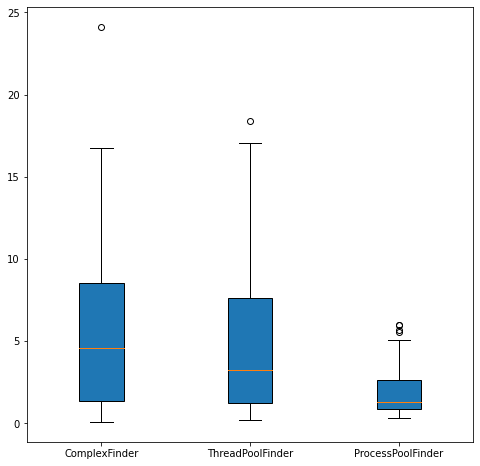

In [21]:
stat.as_boxplot()

# Draw

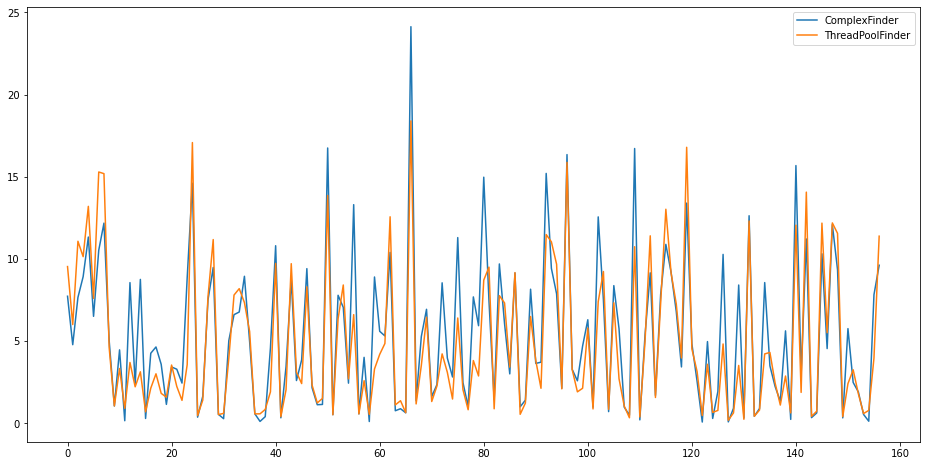

In [25]:
stat.drop([process_pool_finder]).as_plot()

In [51]:
from fp_utils.draw import MoleculeDrawer

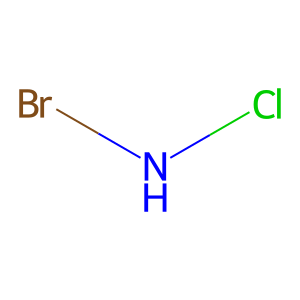

In [62]:
query = 'Br-N-Cl'
# query = queries[0]
MoleculeDrawer.draw_one(query)

In [63]:
answers = search(query, finder, ans_count=10)

7.008s -- search


In [64]:
len(answers)

6

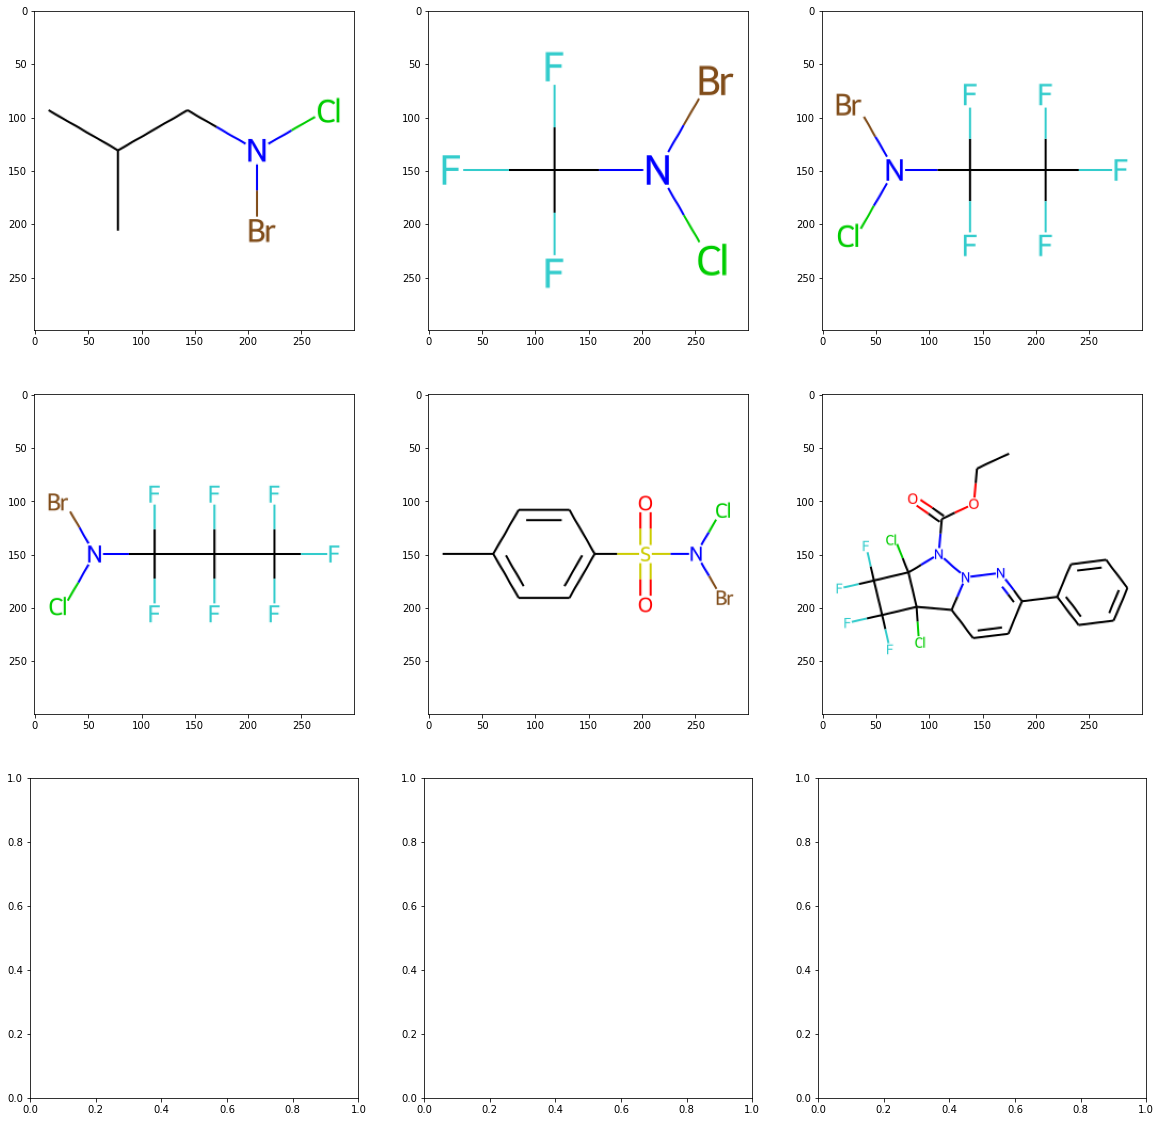

In [65]:
MoleculeDrawer.draw_many(answers, figsize=(20, 20), shape=(3, 3))

# Correctness checks